# Neural Network

Xây dựng neural network với hai tầng ẩn (hidden layer).
Các trọng số và mối liên hệ giữa các tầng ẩn được thiết lập
và cài đặt bằng tay.

## Neural Network Overview

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## MNIST Dataset Overview

MNIST là bộ dữ liệu chứa các ảnh là các ký tự viết tay, chia thành 2 phần, 60000 ảnh dùng để huấn luyện và 10000 ảnh dùng để kiểm thử. Kích thước các ảnh là 28x28, giá trị các pixel thuộc [0,255]


![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [17]:
# Chuẩn bị dữ liệu
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Chuyển đổi sang định dạng float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]).T, x_test.reshape([-1, num_features]).T
# why need to transpose? -> matrix mul

# Chuẩn hóa ảnh từ from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [18]:
x_train.shape 

(784, 60000)

In [19]:
m = x_train.shape[0]

In [20]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [21]:
def init_params():
    W1 = np.random.rand(n_hidden_1, 784) - 0.5
    b1 = np.random.rand(n_hidden_1, 1) - 0.5
    W2 = np.random.rand(n_hidden_2, n_hidden_1) - 0.5
    b2 = np.random.rand(n_hidden_2, 1) - 0.5 
    W3 = np.random.rand(num_classes, n_hidden_2) - 0.5
    b3 = np.random.rand(num_classes, 1) - 0.5
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    tính giá trị cross entropy giữa targets và predictions. 
    Input: predictions (N, k)
           targets (N, k)        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce
    
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def ReLU_deriv(Z):
    return Z > 0

# quite confusing?
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    one_hot_Y = one_hot(Y)
    
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

In [22]:
losses = []
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    # print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        predictions = get_predictions(A3)
        losses.append(cross_entropy(predictions, Y))
        if i % 10 == 9:
            print("Iteration: ", i+1)
            predictions = get_predictions(A3)
            print('Accuracy: %.3f' %(get_accuracy(predictions, Y)))
            print('Iteration: %d, accuracy: %.3f' %(i + 1, get_accuracy(predictions, Y)))
    return W1, b1, W2, b2, W3, b3

In [23]:
alpha = 0.01
n_epoch = 100
W1, b1, W2, b2, W3, b3 = gradient_descent(x_train, y_train, alpha, iterations=n_epoch)

Iteration:  10
Accuracy: 0.099
Iteration: 10, accuracy: 0.099
Iteration:  20
Accuracy: 0.099
Iteration: 20, accuracy: 0.099
Iteration:  30
Accuracy: 0.099
Iteration: 30, accuracy: 0.099
Iteration:  40
Accuracy: 0.099
Iteration: 40, accuracy: 0.099
Iteration:  50
Accuracy: 0.099
Iteration: 50, accuracy: 0.099
Iteration:  60
Accuracy: 0.099
Iteration: 60, accuracy: 0.099
Iteration:  70
Accuracy: 0.099
Iteration: 70, accuracy: 0.099
Iteration:  80
Accuracy: 0.099
Iteration: 80, accuracy: 0.099
Iteration:  90
Accuracy: 0.099
Iteration: 90, accuracy: 0.099
Iteration:  100
Accuracy: 0.099
Iteration: 100, accuracy: 0.099


In [26]:
losses[:20]

[2.1295582328458145,
 67.11354935428119,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09,
 -4.4494793703403155e-09]

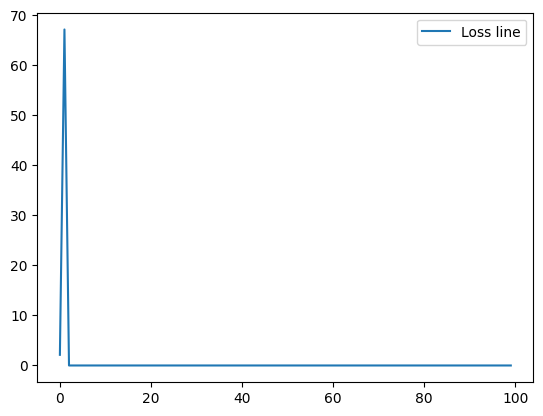

In [24]:
# Biểu đồ biểu diễn độ biến thiên của hàm mất mát qua các vòng lặp
plt.plot([i for i in range(len(losses))], losses, label='Loss line')
# plt.plot(X, np.array(W * X + b), label='Fitted line')
plt.legend()
plt.show()